In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)
conn = engine.connect()

# Exploratory Climate Analysis

In [10]:
inspector = inspect(engine)

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_date = 'SELECT max(date),min(date) FROM Measurement'
last_date = engine.execute(last_date).fetchall()
last_date
# Perform a query to retrieve the data and precipitation scores



last_year_query = "SELECT m.id, m.date, m.prcp, m.tobs,"+\
                    "s.station, s.name, s.latitude,s.longitude," +\
                    "s.elevation " +\
                    "FROM measurement m "+\
                    "INNER JOIN station s " +\
                    "ON m.station = s.station " +\
                    "WHERE date >= '2016-08-23'"



In [12]:
# Save the query results as a Pandas DataFrame and set the index to the date column
last_year_df = pd.read_sql(last_year_query, conn)
last_year_df.head()

,id,date,prcp,tobs,station,name,latitude,longitude,elevation
0,2364,2016-08-23,0.00,81.0,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2365,2016-08-24,0.08,79.0,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
2,2366,2016-08-25,0.08,80.0,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
3,2367,2016-08-26,0.00,79.0,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
4,2368,2016-08-27,0.00,77.0,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0


In [13]:
# Sort the dataframe by date
last_year_df = last_year_df.sort_values('date')
last_year_df = last_year_df.dropna(how = 'any')
# clean up for graph
last_year_summ = last_year_df[['date','prcp']]
last_year_summ = last_year_df.groupby('date').mean()
last_year_summ.head()


,id,prcp,tobs,latitude,longitude,elevation
date,,,,,,
2016-08-23,10074.5,0.451667,78.000000,21.389438,-157.803080,38.233333
2016-08-24,10075.5,1.555000,77.500000,21.389438,-157.803080,38.233333
2016-08-25,9898.0,0.077143,79.428571,21.390004,-157.827654,34.471429
2016-08-26,8348.0,0.016667,80.500000,21.399488,-157.831847,14.816667
2016-08-27,8253.0,0.064000,77.400000,21.400706,-157.803196,15.400000


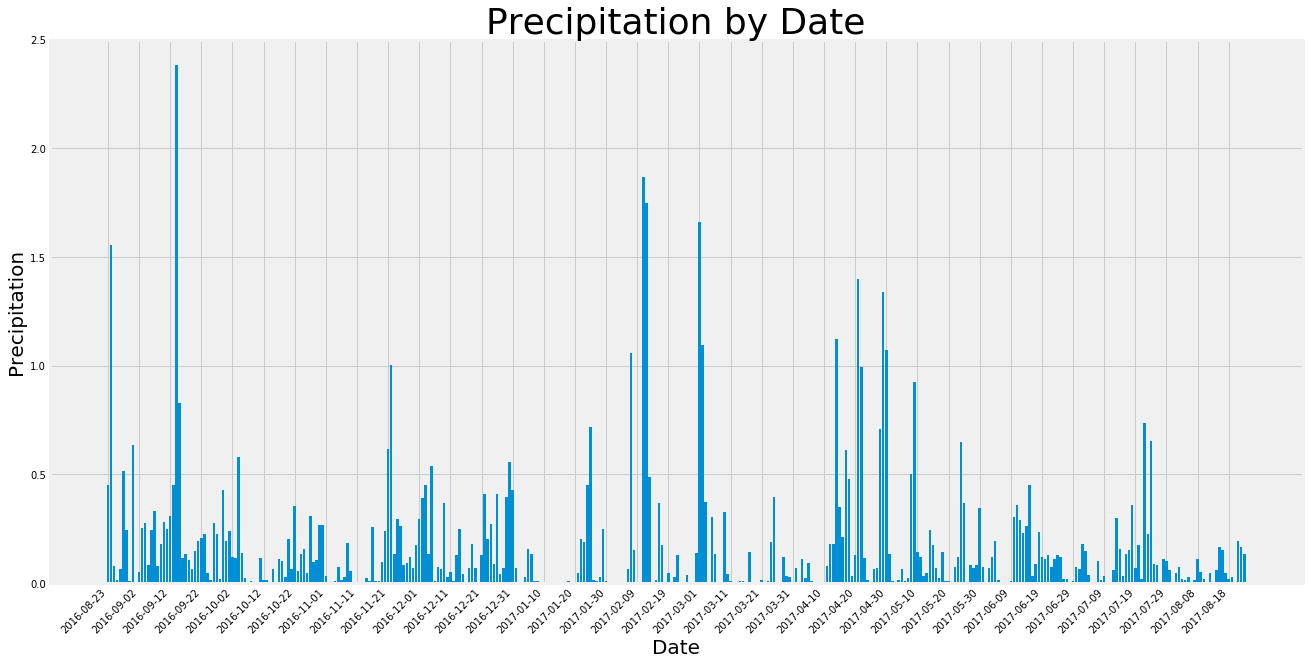

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
last_year_graph = last_year_summ.reset_index()

# graph
plt.bar(last_year_graph['date'], last_year_graph['prcp'])
plt.title('Precipitation by Date', fontsize=36)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Precipitation', fontsize=20)
fig=plt.gcf()
fig.set_size_inches(20, 10)
plt.xticks(rotation=45, ha='right')
plt.xticks(last_year_graph['date'][::10], last_year_graph['date'][::10])
plt.savefig('Precip by Date.png')
plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data

last_year_summ["prcp"].describe()

count    366.000000
mean       0.170757
std        0.295683
min        0.000000
25%        0.008571
50%        0.070000
75%        0.191667
max        2.380000
Name: prcp, dtype: float64

In [16]:
# Design a query to show how many stations are available in this dataset?
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stn_count_query = 'SELECT station, count(id) AS station_cnt ' +\
                    'FROM measurement m ' +\
                    'GROUP BY station ' +\
                    'ORDER BY station_cnt DESC'
stn_count = engine.execute(stn_count_query).fetchall()
stn_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station = stn_count[0][0]

most_active_query = "SELECT station, MIN(tobs), MAX(tobs), AVG(tobs) " + \
                    "FROM measurement " +\
                    f"WHERE station = '{most_active_station}' " +\
                    "GROUP BY station"
info_most_active = engine.execute(most_active_query).fetchall()
info_most_active

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

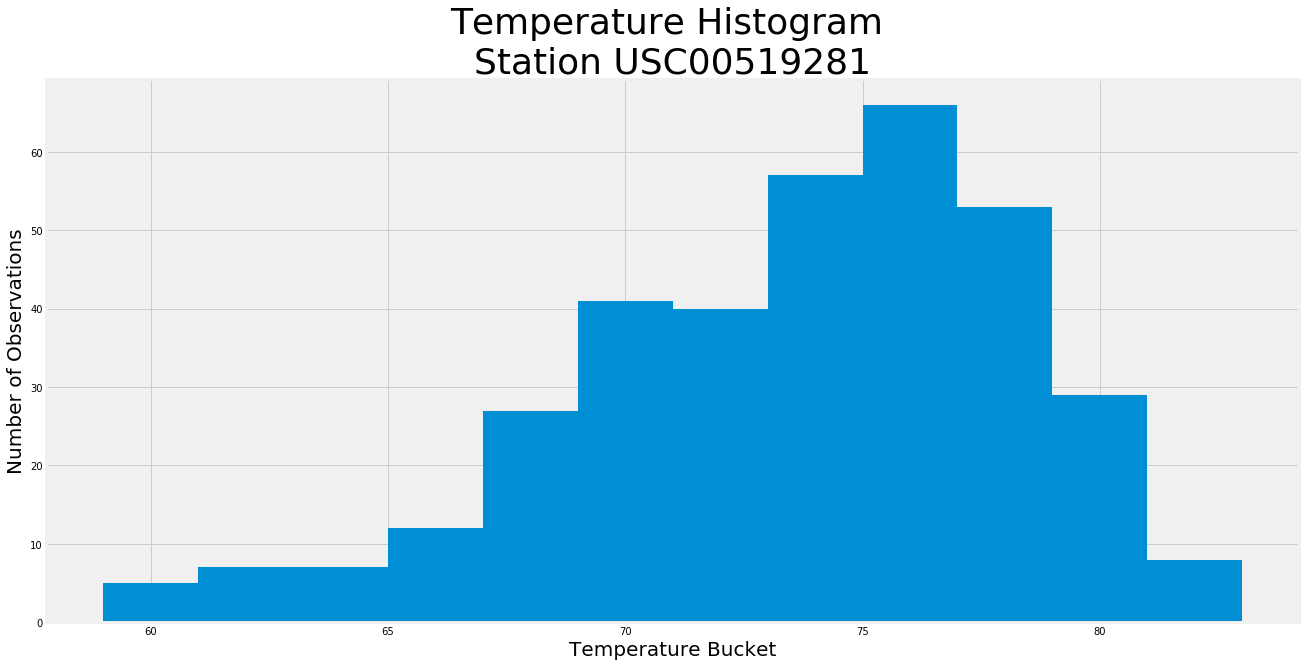

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station 
# and plot the results as a histogram

last_year_most_active = last_year_df[last_year_df['station'] == most_active_station]

plt.hist(last_year_most_active['tobs'], 12)
plt.title(f'Temperature Histogram \nStation {most_active_station}', fontsize=36)
plt.xlabel('Temperature Bucket', fontsize=20)
plt.ylabel('Number of Observations', fontsize=20)
fig=plt.gcf()
fig.set_size_inches(20, 10)
plt.savefig('Temp Histogram.png')
plt.show()



In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
last_temp = calc_temps('2017-02-11', '2017-03-04')
print(last_temp)

[(61.0, 71.1029411764706, 80.0)]


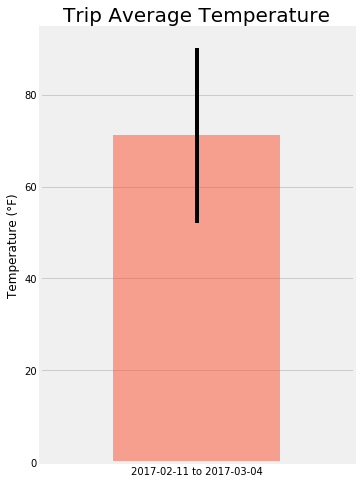

In [21]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.bar('2017-02-11 to 2017-03-04', last_temp[0][1], yerr=last_temp[0][2]-last_temp[0][0], color='C1', alpha=.5)
plt.title('Trip Average Temperature', fontsize=20)
plt.xlim(-0.75, 0.75)
plt.ylabel('Temperature (°F)', fontsize=12)
plt.grid(axis='x')
fig=plt.gcf()
fig.set_size_inches(5, 8)
plt.savefig('Trip Avg Temp.png')
plt.show()

In [22]:
# Calculate the total amount of rainfall per weather station 
# for your trip dates using the previous year's matching dates.

# Sort this in descending order by precipitation amount and 
# list the station, name, latitude, longitude, and elevation

trip_prcp_query = "SELECT s.station, s.name, s.latitude, s.longitude," +\
            "s.elevation, SUM(m.prcp) AS total_prcp " +\
            "FROM measurement m " +\
            "INNER JOIN station s on m.station = s.station " +\
            "WHERE date >= '2017-02-11' " +\
            "AND date <= '2017-03-04'" +\
            "GROUP BY s.station, s.name, s.latitude, s.elevation " +\
            "ORDER BY total_prcp DESC"
trip_prcp_df = pd.read_sql(trip_prcp_query, conn)
trip_prcp_df

,station,name,latitude,longitude,elevation,total_prcp
0,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,10.18
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,10.05
2,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,8.30
3,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,7.10
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,6.25
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,5.56
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,3.15


## Optional Challenge Assignment

In [23]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [24]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
trip_start = "2019-02-11"
trip_end = "2019-03-04"


In [25]:
# Use the start and end date to create a range of dates
trip_dates = pd.date_range(trip_start,trip_end).tolist()
trip_dates
# Stip off the year and save a list of %m-%d strings
trip_dates_m_d = [dt.strftime("%m-%d") for dt in trip_dates]
trip_dates_m_d
# Loop through the list of %m-%d strings and calculate the normals for each date
trip_dates_norm = [daily_normals(mon_day) for mon_day in trip_dates_m_d]
trip_dates_norm

[[(61.0, 69.25, 79.0)],
 [(60.0, 69.15789473684211, 78.0)],
 [(58.0, 70.36206896551724, 80.0)],
 [(62.0, 70.89473684210526, 79.0)],
 [(56.0, 70.28813559322033, 79.0)],
 [(59.0, 70.48214285714286, 76.0)],
 [(62.0, 70.47272727272727, 77.0)],
 [(63.0, 70.79629629629629, 77.0)],
 [(60.0, 69.33962264150944, 77.0)],
 [(63.0, 70.14035087719299, 76.0)],
 [(63.0, 69.79629629629629, 76.0)],
 [(60.0, 70.15789473684211, 83.0)],
 [(62.0, 70.35593220338983, 81.0)],
 [(61.0, 68.56666666666666, 76.0)],
 [(61.0, 68.59649122807018, 76.0)],
 [(62.0, 69.89285714285714, 78.0)],
 [(58.0, 69.98148148148148, 77.0)],
 [(65.0, 70.65517241379311, 80.0)],
 [(64.0, 70.0327868852459, 76.0)],
 [(61.0, 70.36666666666666, 78.0)],
 [(60.0, 70.06896551724138, 78.0)],
 [(57.0, 69.27272727272727, 77.0)]]

In [27]:
last_year_low = [low[0][0] for low in trip_dates_norm]
last_year_avg = [avg[0][0] for avg in trip_dates_norm]
last_year_high = [high[0][0] for high in trip_dates_norm]
#new dataframe to hold information
normals_df = pd.DataFrame(columns = ["date","low","avg","high"])
normals_df["date"] = trip_dates_m_d
normals_df["low"] = last_year_low
normals_df["avg"] = last_year_avg
normals_df["high"] = last_year_low
normals_df = normals_df.set_index(['date'])
normals_df

,low,avg,high
date,,,
02-11,61.0,61.0,61.0
02-12,60.0,60.0,60.0
02-13,58.0,58.0,58.0
02-14,62.0,62.0,62.0
02-15,56.0,56.0,56.0
02-16,59.0,59.0,59.0
02-17,62.0,62.0,62.0
02-18,63.0,63.0,63.0
02-19,60.0,60.0,60.0


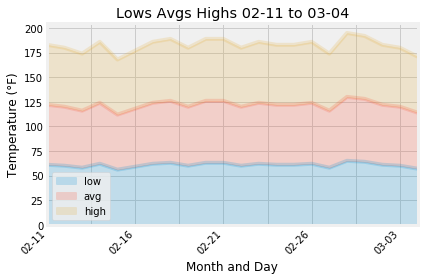

In [46]:
normals_df.plot(kind = "area", stacked = "False", x_compat=True, alpha = 0.2)
plt.title('Lows Avgs Highs 02-11 to 03-04')
plt.xlabel("Month and Day")
plt.ylabel("Temperature (°F)")
plt.xticks(rotation=45, ha='right')

plt.tight_layout()